In [1]:
#auxiliary tools
import os
import re
from typing import Tuple, Union, List, Optional, Iterable, Any
from tqdm import tqdm

#math core and data handling
import numpy as np
import pandas as pd
import segyio
from scipy.interpolate import Rbf, interp1d
from scipy.signal import butter, tukey, filtfilt


#visualization core (+global settings)
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "century"

# Data loading

In [2]:
class Well:
    def __init__(self, filepath_dtp: Optional[str] = None, filepath_rhob: Optional[str] = None, delimiter : str ="\t", dtype=np.single):
        """
        Constructor for the Well class.

        Parameters:
        - filepath_dtp: Filepath for the sonic log (dtp).
        - filepath_rhob: Filepath for the density log (rhob).
        - delimiter: Delimiter used in the log files. Default is '\t' (tab).
        - dtype: Data type to be used when reading the log files. Default is np.single.
        """
        self.filepath_dtp = filepath_dtp
        self.filepath_rhob = filepath_rhob
        
        if self.filepath_dtp and self.filepath_rhob:
            if not (os.path.isfile(self.filepath_dtp) and self.filepath_dtp.endswith('.txt') and
                    os.path.isfile(self.filepath_rhob) and self.filepath_rhob.endswith('.txt')):
                print("TXT-logfile not found or invalid file extension.")
                self._initialize_empty()
                return

            self.name_dtp = os.path.basename(self.filepath_dtp)
            self.name_rhob = os.path.basename(self.filepath_rhob)

            self.index = int(re.search(r'\d+', self.name_dtp).group())

            self.data = {'dtp': None, 'rhob': None}

            try:
                self.data['dtp'] = self._read_txt(self.filepath_dtp, delimiter, dtype)
                self.data['rhob'] = self._read_txt(self.filepath_rhob, delimiter, dtype)

                self.data['dtp'], self.data['rhob']  = self._trim_array(self.data['dtp'], self.data['rhob'])
                #rearanging dictionary
                self.data = {
                             "x" : self.data['rhob'][:, 0],
                             "y" : self.data['rhob'][:, 1],
                             "time" : self.data['rhob'][:, 2],
                             "dtp" : self.data['dtp'][:, 3],
                             "rhob" : self.data['rhob'][:, 3]
                             }
    
                print("--File uploading has passed successfully--")
            except Exception as e:
                print(f"Error reading data from files: {e}")
                self._initialize_empty()
        else:
            print("Filepaths not provided.")

    def _read_txt(self, filepath, delimiter, dtype):
        """
        Method to read data from a text file and return it as a numpy array.
        """
        with open(filepath, "r") as txt:
            next(txt)  # Skip header
            data = np.loadtxt(txt, delimiter=delimiter, dtype=dtype)

        return data
    
    def _initialize_empty(self):
        """
        Method to initialize attributes to None when file reading fails.
        """
        self.data = {
                "x" : None,
                "y" : None,
                "time" : None,
                "dtp" : None,
                "rhob" : None
                }
        self.name_dtp = None
        self.name_rhob = None
        self.index = None

    def _trim_array(self, array_1 : Iterable[Any], array_2: Iterable[Any]) -> Tuple[Iterable[Any], Iterable[Any]]:
        """
        Trim two arrays to have the same length.
        """

        min_len = min(len(array_1), len(array_2))

        return array_1[:min_len], array_2[:min_len]




    def __repr__(self):
        """
        String representation of the Well object.
        """
        return f'name_dtp: {self.name_dtp}\nname_rhob: {self.name_rhob}\nindex: {self.index}\nx_coord: {self.data["x"][0]}\ny_coord: {self.data["y"][0]}'

class Data_handling:
    def __init__(self, impulses_path: Optional[str] = None, 
                 wells_path: Optional[str] = None, 
                 horizons_path: Optional[str] = None, 
                 cube_path: Optional[str] = None):
        """
        :param impulses_path: путь к фолдеру импульсов.
        :param wells_path: путь к фолдеру ласов.
        :param horizons_path: путь к фолдеру горизонтов.
        :param cube_path: путь к SEGY файлу сейсмокуба.
        """

        self.impulses_folder_path = impulses_path
        self.wells_folder_path = wells_path
        self.horizons_folder_path = horizons_path
        self.cube_folder_path = cube_path


        if self.impulses_folder_path:
            if not os.path.isfile(self.impulses_folder_path):
                print("impulses_path not found.\n")

        if self.wells_folder_path:
            if not os.path.isfile(self.wells_folder_path):
                print("wells_path not found.\n")

        if self.horizons_folder_path:
            if not os.path.isfile(self.horizons_folder_path):
                print("horizons_path not found.\n")

        if self.cube_folder_path:
            if not os.path.isfile(self.cube_folder_path):
                print("cube_path not found.\n")


        
    @staticmethod   
    def parse_cubes_in_folder(cube_path: str):
        all_cubes = []  # лист для кубов

        try:
            for filename in os.listdir(cube_path):
                file_path = os.path.join(cube_path, filename) 
                if os.path.isfile(file_path):  
                    all_cubes.append(segyio.tools.cube(file_path))

        except FileNotFoundError:
            print(f"Folder '{cube_path}' not found.")
        except Exception as e:
            print("An error occurred:", e)

        return all_cubes  
    @staticmethod
    def interpolate_signal(signal):
        """
        :param signal: сигнал для интероляции.
        :return: ресемплированный нормированный сигнал.
        """
        interp_func = interp1d(np.arange(len(signal)), signal, kind='cubic')

        new_x = np.linspace(0, len(signal) - 1, 100)

        new_signal = interp_func(new_x)
    
        return new_signal / np.max(new_signal)
    
    @staticmethod
    def parse_signals_in_folder(impulses_folder_path: str):
        all_txt = []  # лист для вейвлетов

        try:
            for filename in os.listdir(impulses_folder_path):
                file_path = os.path.join(impulses_folder_path, filename) 
                if os.path.isfile(file_path):  
                    all_txt.append(np.loadtxt(file_path))

        except FileNotFoundError:
            print(f"Folder '{impulses_folder_path}' not found.")
        except Exception as e:
            print("An error occurred:", e)

        return all_txt  
    
    @staticmethod
    def parse_wells_in_folder(wells_folder_path: str):
        """
        
        Parse well log data from LAS files in the specified folder.

        Считывает LAS файлы, выбирает нужные кривые, собирает их в NumPy array.
        RHOB, DTP, DPTM.

        Returns:
            all_lases (list): Лист NumPy arrays с нужными каротажками.
        """
        all_lases = []  

        try:
            for filename in os.listdir(wells_folder_path):
                if filename.endswith('.LAS'):
                    file_path = os.path.join(wells_folder_path, filename)  
                    if os.path.isfile(file_path): 
                        las = lasio.read(file_path)  
                        all_lases.append(np.column_stack((las["DEPTH"].T, las["RHOB"].T, 1e7/las["DTP"].T, las["DPTM"])))

        except FileNotFoundError:
            print(f"Folder '{wells_folder_path}' not found.")
        except Exception as e:
            print("An error occurred:", e)

        return all_lases  
    @staticmethod
    def parse_horizons_in_folder(horizons_folder_path: str):
        """
        Считывает файлы горизонтов из фолдера (Charisma dtype).

        Returns:
            all_horizons (list): Лист NumPy arrays с горизонтами.
        """
        all_horizons = [] 
        try:
            for filename in os.listdir(horizons_folder_path):
                file_path = os.path.join(horizons_folder_path, filename)  
                if os.path.isfile(file_path): 
                    with open(file_path, "r") as f:
                        horizon = np.loadtxt(f, skiprows=0, usecols=(2,5,8)).astype(np.float32)
                        all_horizons.append(horizon) 
        except FileNotFoundError:
            print(f"Folder '{horizons_folder_path}' not found.")
        except Exception as e:
            print("An error occurred:", e)

    
        def get_surfaces(horizon):
            """
            Собирает 2D массив горизонта.

            :param horizon: NumPy array с X, Y и Z координатами.
            :return: A 2D NumPy array горизонта.
            """
            min_Y, max_Y = np.min(horizon[:, 1]), np.max(horizon[:, 1])
            min_X, max_X = np.min(horizon[:, 0]), np.max(horizon[:, 0])
            X = np.arange(min_X, max_X, dtype="int32")
            Y = np.arange(min_Y, max_Y, dtype="int32")
            surf = np.empty((X.shape[0], Y.shape[0]))

            for i in range(horizon.shape[0]):
                x_index = (horizon[i, 0] - min_X - 1).astype("int32")
                y_index = (horizon[i, 1] - min_Y - 1).astype("int32")
                surf[x_index, y_index] = horizon[i, 2] / 2

            return surf
        surfaces = [get_surfaces(horizon) for horizon in all_horizons]

        return all_horizons, surfaces

In [3]:
def divide_filenames_by_keyword(directory: str, keywords: Optional[List[str]] = ["dtp", "rhob"]) -> Tuple[list, list]:
    dtp_files, rhob_files = [], []

    for filename in os.listdir(directory):
        # Convert filename to lowercase for case-insensitive matching
        lowercase_filename = filename.lower()
        if keywords[0] in lowercase_filename:
            dtp_files.append(os.path.join(directory, filename))
        elif keywords[1] in lowercase_filename:
            rhob_files.append(os.path.join(directory, filename))

    return dtp_files, rhob_files

def butter_lowpass_filter(data, cutoff, fs, order):
    """
    Lowpass filter
    fs - sample rate (шаг дискретизации), Hz
    cutoff - desired cutoff frequency of the filter (желаемая частота среза фильтра), Hz
    order - sin wave can be approx represented as quadratic
    """
    normal_cutoff = 2*cutoff / fs
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def r2even(f) -> int:
    if (np.floor(f)%2 == 0): 
        return np.floor(f)
    else: 
        return np.floor(f)+1
    
def interp(x: Iterable[float], y: Iterable[float], step: Union[int, float], 
           kind : Optional[str] = "cubic", fill_value : Optional[str] = "extrapolate"):
    """
    func takes 2 numpy.arrays (x,y by default) and desired step for the first array
    than, it interpolates values y for new x:

    input:
    x -> np.array([1, 2, 3, 4, 5, 6])
    y -> np.array([10, 15, 20, 25, 30, 35])
    step - > 1.5

    output:
    x_new -> np.array([1, 2.5, 4, 5.5])
    y_new -> np.array([10, 17.5, 25, 32.5])

    you can also adjust the inner parameters of the interplate.interp1d func (kind, fill_value)
    which are "cubic" and "extrapolate" by default
    """
    #exceptions
    if not isinstance(x, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("Input 'x' and 'y' must be NumPy arrays")
    if x.shape != y.shape:
        raise ValueError("Input 'x' and 'y' must have the same shape")

    #functional block       
    f = interp1d(x, y, kind=kind, fill_value=fill_value)
    xnew = np.arange(r2even(x[0]), r2even(x[-1])+1, step)
    ynew = f(xnew)
    return xnew, ynew

In [4]:
folder = r"C:\Users\Владислав\Desktop\LOG _unique"

dtp_dir, rhob_dir = divide_filenames_by_keyword(folder)

dir_df = pd.DataFrame({"dtp": dtp_dir, "rhob" : rhob_dir})
dir_df.iloc[:5]

,dtp,rhob
0,C:\Users\Владислав\Desktop\LOG _unique\Болтная...,C:\Users\Владислав\Desktop\LOG _unique\Болтная...
1,C:\Users\Владислав\Desktop\LOG _unique\Казанск...,C:\Users\Владислав\Desktop\LOG _unique\Казанск...
2,C:\Users\Владислав\Desktop\LOG _unique\Казанск...,C:\Users\Владислав\Desktop\LOG _unique\Казанск...
3,C:\Users\Владислав\Desktop\LOG _unique\Казанск...,C:\Users\Владислав\Desktop\LOG _unique\Казанск...
4,C:\Users\Владислав\Desktop\LOG _unique\Казанск...,C:\Users\Владислав\Desktop\LOG _unique\Казанск...


In [5]:
# Creation of Well class objects for each file in pointed directory
wells = [Well(dir_df.iloc[i, :]["dtp"], dir_df.iloc[i, :]["rhob"]) for i in range(dir_df.shape[0])]


--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uploading has passed successfully--
--File uplo

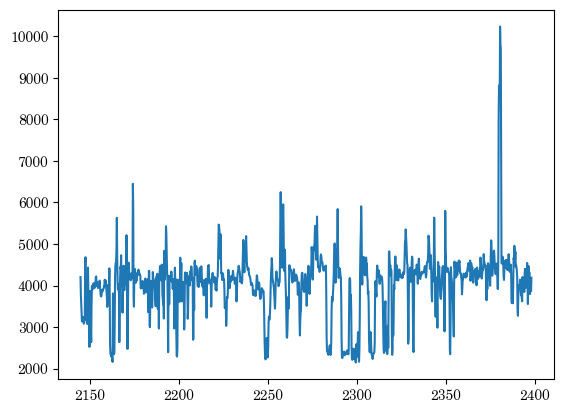

In [6]:
plt.plot(wells[2].data["time"], 1e6/wells[2].data["dtp"])

In [7]:
"""np.r_ is a short concatenation method"""
x_decimated = [np.r_['r', interp(wells[i].data["time"], 1e6/wells[i].data["x"], 2, kind = "nearest")].T for i in range(dir_df.shape[0])]

y_decimated = [np.r_['r', interp(wells[i].data["time"], 1e6/wells[i].data["y"], 2, kind = "nearest")].T for i in range(dir_df.shape[0])]

dtp_decimated = [np.r_['r', interp(wells[i].data["time"], 1e6/wells[i].data["dtp"], 2, kind = "nearest")].T for i in range(dir_df.shape[0])]

rhob_decimated = [np.r_['r', interp(wells[i].data["time"], wells[i].data["rhob"], 2, kind = "nearest")].T for i in range(dir_df.shape[0])]

ai_decimated = [np.array(dtp_decimated[i][:, 1])*np.array(rhob_decimated[i][:, 1]) for i in range(dir_df.shape[0])]

In [8]:
"""
18/04/2024
Закончил на том, что сделал децимацию каротажек и продумал обрезку по самой короткой из двух
Дальше нужно перевести медленность в скорость (ПРАВИЛЬНО!) и посчитать импеданс
Пришить это все к глубинам 
Расчитать inline/crossline для каждой скважины (интерполяция инклинометрии)
31 индекс косячный, посмотреть (kaz_K21_294)

19/04/2024
Переписал логику под ООП, теперь каждая скважина - объект, имеющий свои атрибуты. 
Так удобно работать, больше контроля над данными и можно избежать тупых факапов 
(как например с переводом медленности в скорость)
Перевел скорости в медленности и расчитал импеданс для каждой скважины,
запросил уточнения по выбросу в скважине kaz_K21_294 и по поводу пустого файла

Дальше:
Перевод inline/crossline, добавить как атрибуты класса
Разбиение на интервалы
Интерполяция (создание НЧМ)


""" 

'\n18/04/2024\nЗакончил на том, что сделал децимацию каротажек и продумал обрезку по самой короткой из двух\nДальше нужно перевести медленность в скорость (ПРАВИЛЬНО!) и посчитать импеданс\nПришить это все к глубинам \nРасчитать inline/crossline для каждой скважины (интерполяция инклинометрии)\n31 индекс косячный, посмотреть (kaz_K21_294)\n\n19/04/2024\nПереписал логику под ООП, теперь каждая скважина - объект, имеющий свои атрибуты. \nТак удобно работать, больше контроля над данными и можно избежать тупых факапов \n(как например с переводом медленности в скорость)\nПеревел скорости в медленности и расчитал импеданс для каждой скважины,\nзапросил уточнения по выбросу в скважине kaz_K21_294 и по поводу пустого файла\n\nДальше:\nПеревод inline/crossline, добавить как атрибуты класса\nРазбиение на интервалы\nИнтерполяция (создание НЧМ)\n\n\n'

In [9]:
for i in range(dir_df.shape[0]):
    wells[i].data_decimated = {"dtp": dtp_decimated[i], "rhob": rhob_decimated[i]}
    wells[i].data_decimated = {
                "x" : x_decimated[i][:, 1],
                "y" : y_decimated[i][:, 1],
                "time" : y_decimated[i][:, 0],
                "dtp" : dtp_decimated[i][:, 1],
                "rhob" : rhob_decimated[i][:, 1],
                "impedance" : ai_decimated[i]
                }

Казанская 16р_DTp.txt
Казанская 18р_DTp.txt
Казанская 20р_DTp.txt
Казанская_К39 3901_DTp.txt


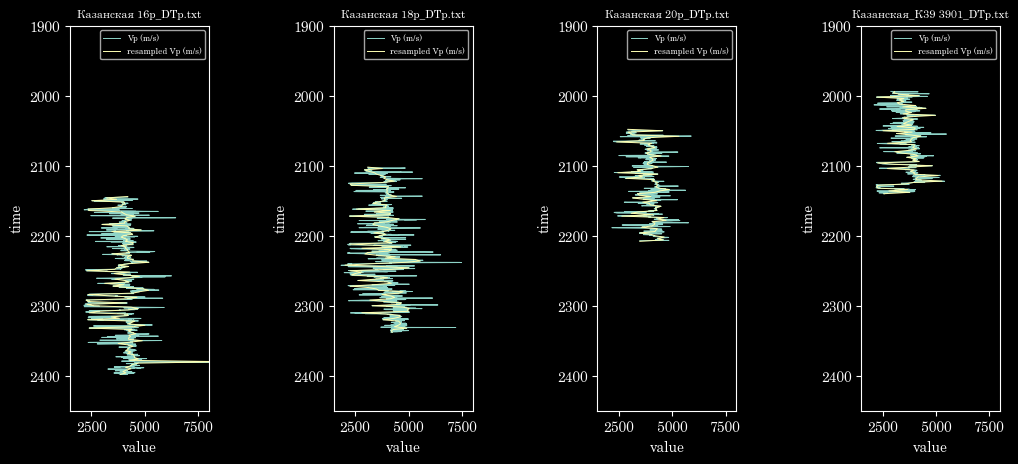

In [19]:
plt.style.use('dark_background')
plt.rcParams["font.family"] = "century"
plt.figure(figsize = (12, 5))


w_num =  [2, 3, 5, 33]
# for i in range(30, 40, 1):
for sub, i in enumerate(w_num):
    plt.subplot(1, len(w_num), sub + 1)
    plt.subplots_adjust(wspace=0.9, hspace=0.4)
    print(wells[i].name_dtp)

    plt.plot(1e6/wells[i].data["dtp"], wells[i].data["time"], lw = 0.7,  label = "Vp (m/s)")
    plt.plot(wells[i].data_decimated["dtp"], wells[i].data_decimated["time"], lw = 0.7, label = "resampled Vp (m/s)")

   
    plt.ylim([1900, 2450])
    plt.xlim([1500, 8000])
    plt.gca().invert_yaxis()
    plt.legend(loc = 0, fontsize = 6)
    plt.title("%13s" % wells[i].name_dtp, fontsize = 8)
    plt.ylabel("time")
    plt.xlabel("value")


In [11]:
wells[0]

name_dtp: Болтная 130_DTp.txt
name_rhob: Болтная 130_RHOB.txt
index: 130
x_coord: 378313.0
y_coord: 239789.0

In [12]:
5625-4018

1607

In [13]:
well_x = [wells[i].data["x"][0] for i in range(len(wells))]
well_y = [wells[i].data["y"][0] for i in range(len(wells))]

cube_x = [358071, 383139, 347539, 372607]
cube_y = [228572, 235382, 267342, 274152]

cube_inl = np.array([4018, 4018, 5625, 5625]) - 4018
cube_crl = np.array([694, 1733, 694, 1733]) - 694

In [14]:
step_y = ((cube_x[0] - cube_x[2])**2 + (cube_y[0] - cube_y[2])**2)**0.5/1607

step_x = ((cube_x[0] - cube_x[1])**2 + (cube_y[0] - cube_y[1])**2)**0.5/1039

step_x, step_y

(25.00148392894341, 25.000041038530874)

In [15]:
all_xes_in = np.linspace(cube_x[0], cube_x[1], 1607)
all_yes_in = np.linspace(cube_y[0], cube_y[1], 1607)

all_xes_cr = np.linspace(cube_x[0], cube_x[2], 1039)
all_yes_cr = np.linspace(cube_y[0], cube_y[2], 1039)

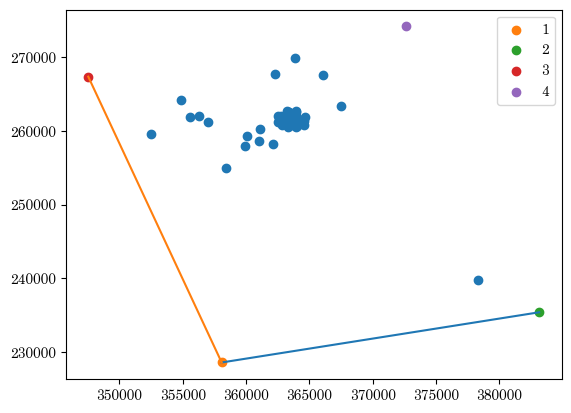

In [16]:
plt.scatter(well_x, well_y)
for i in range(len(cube_x)):
    plt.scatter(cube_x[i], cube_y[i], label = str(i+1))
plt.legend(loc = 0)

plt.plot(all_xes_in, all_yes_in)
plt.plot(all_xes_cr, all_yes_cr)


In [17]:
np.diff(all_xes_cr)
# np.diff(all_xes_cr)

array([-10.14643545, -10.14643545, -10.14643545, ..., -10.14643545,
       -10.14643545, -10.14643545])

In [18]:
inlines = []
crosslines = []
for loc in range(len(wells)):
    dist_folder_inlines = []
    for i in range(1607):
        distance_in = np.sqrt((wells[loc].data["x"][0]  - all_xes_in[i])**2 + (wells[loc].data["y"][0] - all_yes_in[i])**2)
        dist_folder_inlines.append(distance_in)
    inlines.append(np.int32(min(dist_folder_inlines)/25))
    dist_folder_crosslines = []
    for j in range(1039):
        distance_cr = np.sqrt((wells[loc].data["x"][0] - all_xes_cr[j])**2 + (wells[loc].data["y"][0] - all_yes_cr[j])**2)
        dist_folder_crosslines.append(distance_cr)
    crosslines.append(np.int32(min(dist_folder_crosslines)/25))
        
        


In [19]:
for i in range(len(wells)):
    print(f"{np.c_['r', inlines, crosslines][i, :]} label: {wells[i].name_dtp}")

[[220 898]] label: Болтная 130_DTp.txt
[[1467  572]] label: Казанская 14р_DTp.txt
[[1533  658]] label: Казанская 16р_DTp.txt
[[1254  110]] label: Казанская 18р_DTp.txt
[[1407  248]] label: Казанская 19р_DTp.txt
[[1016  288]] label: Казанская 20р_DTp.txt
[[1214  515]] label: Казанская_К18 309_DTp.txt
[[1241  522]] label: Казанская_К18 310_DTp.txt
[[1179  537]] label: Казанская_К18 311_DTp.txt
[[1172  561]] label: Казанская_К18 312_DTp.txt
[[1261  557]] label: Казанская_К18 316_DTp.txt
[[1206  543]] label: Казанская_К18 317_DTp.txt
[[1199  569]] label: Казанская_К18 319_DTp.txt
[[1227  577]] label: Казанская_К18 325_DTp.txt
[[1253  584]] label: Казанская_К18 326_DTp.txt
[[1218  604]] label: Казанская_К18 328_DTp.txt
[[1214  524]] label: Казанская_К18 751_DTp.txt
[[1195  520]] label: Казанская_К18 761_DTp.txt
[[1232  553]] label: Казанская_К18 764_DTp.txt
[[1255  560]] label: Казанская_К18 765_DTp.txt
[[1184  540]] label: Казанская_К18 767_DTp.txt
[[1203  572]] label: Казанская_К18 769_DT

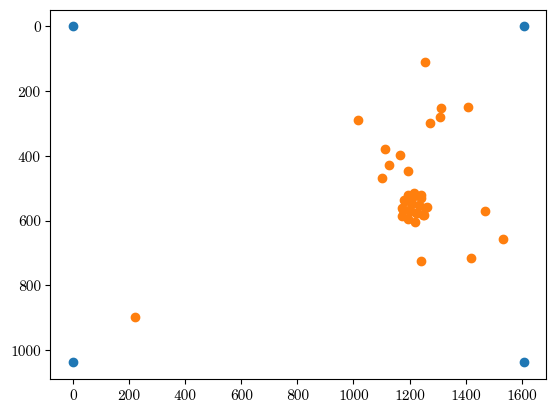

In [20]:
plt.scatter(cube_inl, cube_crl)
plt.scatter(inlines, crosslines)
plt.gca().invert_yaxis()

In [21]:
cube_folder = r"C:\Users\Владислав\Desktop\kazan\cubes_folder"
wavelets_path = r"C:\Users\Владислав\Desktop\kazan\wavelets_folder"
horizons_path = r"C:\Users\Владислав\Desktop\kazan\horizons_folder"

In [24]:
stack = Data_handling.parse_cubes_in_folder(cube_folder)

wavelets = np.asarray(Data_handling.parse_signals_in_folder(wavelets_path))

horizons, surfaces = Data_handling.parse_horizons_in_folder(horizons_path)


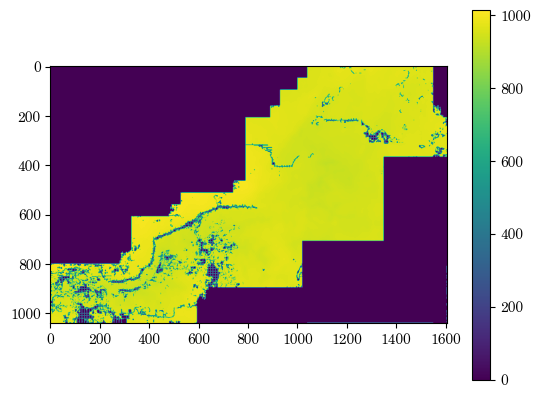

In [25]:
plt.imshow(surfaces[5].T)
# plt.scatter(inlines, crosslines, c = "red", s = 10)
plt.colorbar()


In [26]:
wells[0].data_decimated["time"]

matrix([[2262.],
        [2264.],
        [2266.],
        [2268.],
        [2270.],
        [2272.],
        [2274.],
        [2276.],
        [2278.],
        [2280.],
        [2282.],
        [2284.],
        [2286.],
        [2288.],
        [2290.],
        [2292.],
        [2294.],
        [2296.],
        [2298.],
        [2300.],
        [2302.],
        [2304.],
        [2306.],
        [2308.],
        [2310.],
        [2312.],
        [2314.],
        [2316.],
        [2318.],
        [2320.],
        [2322.],
        [2324.],
        [2326.],
        [2328.],
        [2330.],
        [2332.],
        [2334.],
        [2336.],
        [2338.],
        [2340.],
        [2342.],
        [2344.],
        [2346.],
        [2348.],
        [2350.],
        [2352.],
        [2354.]])

In [35]:

def interpolate_surfaces(surface, horizon): 
    indices_start = [] 
    indices_end = [] 
    for i in range(surface.shape[0]): 
        folder_start = [] 
        folder_end = [] 
        for j in range(surface.shape[1]): 
            if surface[i, j] != 0: 
                folder_start.append(j) 
        for k in range(surface.shape[1]-1, 0, -1): 
            if surface[i, k] != 0: 
                folder_end.append(k) 
        indices_start.append(folder_start[0]) 
        indices_end.append(folder_end[0]) 
 
    surface1 = np.copy(surface) 
 
    for i in tqdm(range(surface.shape[0])): 
        curve = np.where(horizon[:, 0]-4018 == i) 
        f = Rbf(horizon[curve, 0]-4018,horizon[curve, 1]-694, horizon[curve, 2]/2, normalize=True, epsilon=1, smooth=0.005, shape=40)    
        for j in range(surface.shape[1]): 
            if indices_start[i]<= j <= indices_end[i] and surface[i,j] == 0: 
                surface1[i,j] = f(i, j) 
 
    return surface1, indices_start, indices_end

In [41]:
surfaces = np.array(surfaces, dtype=np.single)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (11,) + inhomogeneous part.

In [42]:
surfaces[6][600:, -1] = 0
surfaces[6][700:, 900:] = 0
surfaces[3][700:, 900:] = 0
surfaces[6][-1, 400:] = 0    



for i in range(len(surfaces)):
    surfaces[i] = surfaces[i][:1605, :1037]
surfaces_i = np.empty_like(surfaces)

for i in range(len(surfaces)):
    folder = interpolate_surfaces(surfaces[i], horizons[i])
    surfaces_i[i] = folder[0]

# surfaces = np.array(surfaces, dtype=np.single)


100%|██████████| 1605/1605 [00:44<00:00, 36.18it/s]


In [43]:
surfaces_i[6][600:, -1] = 0
surfaces_i[6][700:, 900:] = 0
surfaces_i[3][700:, 900:] = 0
surfaces_i[6][-1, 400:] = 0   
for i in range(len(surfaces)):
    surfaces_i[i][0, :] = 0     

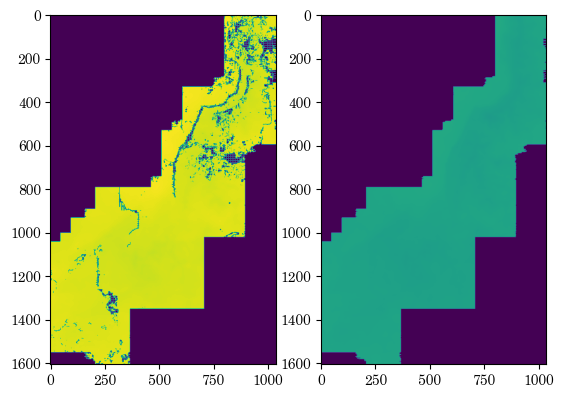

In [44]:
num = 5
plt.subplot(121)
plt.imshow(surfaces[num])

plt.subplot(122)
plt.imshow(surfaces_i[num])

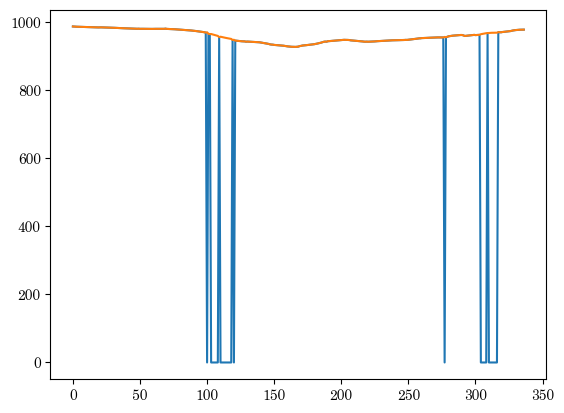

In [45]:
plt.plot(surfaces[num][400, 700:])
plt.plot(surfaces_i[num][400, 700:])

In [46]:
for k in tqdm(range(7)):
    for m in range(7):
        for i in range(surfaces_i[1].shape[0]):
            for j in range(surfaces_i[1].shape[1]):
                if surfaces_i[k][i,j] - surfaces_i[m][i,j] == surfaces_i[k][i,j]:
                    surfaces_i[k][i,j] = 0

100%|██████████| 7/7 [01:09<00:00,  9.99s/it]
